In [286]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from load_vector_non_smooth import elemental_load_vector_non_smooth_solution
from stiffness_matrix import stiffness_matrix
from load_vector import load_vector
matplotlib.rcParams.update({'font.size': 7})

### Utilities

In [287]:
def midpoint_rule(f, dx):
    return (f[2:] - f[:-2]) / (2*dx)

def simpsons_rule(f, dx):
    return dx * (f[0] + 4*np.sum(f[1:-1:2]) + 2*np.sum(f[2:-1:2]) + f[-1]) / 3

def sobolev_norm(f, dx):
    '''
    function to calculate H1-norm.
    - f: array with function values
    - dx: h
    '''
    # Calculate the derivative of f using the midpoint rule
    df = np.zeros_like(f)
    df[1:-1] = midpoint_rule(f, dx)
    # Calculate the L^2 norm of f and df using Simpson's rule
    l2_norm_f = np.sqrt(simpsons_rule(f**2, dx))
    l2_norm_df = np.sqrt(simpsons_rule(df**2, dx))
    # Calculate the H^1 norm of f
    h1_norm_f = np.sqrt(l2_norm_f**2 + l2_norm_df**2)
    return h1_norm_f


def loglog_error(f, u = None, norm='inf'):
    '''
    for calculating the error of FEM. returns array of errors e for different h found in the returned array H.
    - f: r.h.s function for the given solution u
    - u: solution to problem
    - norm: which norm should be used to calculate the error
    '''
    iterations = 50
    M = np.logspace(1,2,iterations, dtype=int)
    print(M)
    H = 1/M
    e = np.zeros_like(H)
    for i in range(iterations):
        X = np.linspace(0, 1, M[i])
        h = 1/M[i]
        A = stiffness_matrix(alpha=1, b=1, c=2, H=np.full_like(X, h), M=len(X))
        F = load_vector(f, X, len(X))
        u_num = np.linalg.solve(A, F)
        if norm == 'inf':
            e[i] = np.max(np.abs(u(X[1:-1]) - u_num))
        elif norm == 'L2':
            e[i] = np.sqrt(simpsons_rule((u(X[1:-1]) - u_num)**2, h)) # np.sum((u(X[1:-1]) - u_num)**2))
        elif norm == 'H1':
            e[i] = sobolev_norm(u(X[1:-1]) - u_num, h)
    return e, H


def loglogplot_error(h, e, ax=None):
    ''' 
    plotting function. uses logarithmic ploting scale
    - h: array of h-values
    - e: array with error values
    - ax: potential given plt object'''

    if ax is None:
        _, ax = plt.subplots()

    p = np.polyfit(np.log(h), np.log(e), 1)[0]

    ax.set_title("Error")
    ax.loglog(h, e, label=f"p={p:.3f}")
    ax.set_xlabel("h")
    ax.set_ylabel("e")
    #ax.invert_xaxis()
    plt.legend()
    return plt


def loglog_mainplot(solution_data, error_data, just_inf_norm=False):
    '''
    - solution_data: a 3d array with data assigned to respective ax alon first dim, data assign to num or anal along second dim
      and x and y along third dim
    - error_data: 2d arr with data assigned to respective ax along first dim, x and y values along second dim.
    '''
    fig, ax = plt.subplots(len(solution_data), 1 + int(len(error_data)/2))
    fig.set_figwidth(12)
    fig.set_figheight(4)
    # first solution plot
    ax[0].plot(solution_data[0,0], solution_data[0,1], label='analytical')
    ax[0].plot(solution_data[1,0], solution_data[1,1], label='numerical', linestyle='dashed')
    plt.legend()

    # second solution plot
    ax[1 + int(len(error_data)/2)].plot(solution_data[2,0], solution_data[2,1], label='analytical')
    ax[1 + int(len(error_data)/2)].plot(solution_data[3,0], solution_data[3,1], label='numerical', linestyle='dashed')
    plt.legend()

    # if we are just interested in plotting the error with the use of infinity norm
    if just_inf_norm:
        loglogplot_error(error_data[0,0], error_data[0,1], ax[1])
        loglogplot_error(error_data[0,0], error_data[0,1], ax[3])

    # if we want to plot more types of error-calculations
    else:
        loglogplot_error(error_data[0,0], error_data[0,1], ax[1])
        loglogplot_error(error_data[1,0], error_data[1,1], ax[2])
        loglogplot_error(error_data[2,0], error_data[2,1], ax[4])
        loglogplot_error(error_data[3,0], error_data[3,1], ax[5])


# Example using a solution with constant rhs

Let $c_1=-\frac{e^2 + e}{e^2 + e + 1}$, $c_1=-\frac{1}{e^2 + e + 1}$, and
$$
u(x)=c_1e^{-x} + c_2 e^{2x} + 1
$$
Then, using $\alpha=1$, $b=1$ and $c=2$, we have
$$
f(x)=-(Lu)(x) = 2
$$
This results in the elemental load vector
$$
\vec{F}^{K_i} = h_i (1, 1)^T
$$

In [288]:
M = 100
X = np.sort(np.random.random(M))
X[[0, -1]] = [0, 1]
H = np.diff(X)

def f(x):
    return 2

A = stiffness_matrix(alpha=1, b=1, c=2, H=H, M=M)
F = load_vector(f, X, M)

In [289]:
U = np.linalg.solve(A, F)

In [290]:
def u(x):
    return (-np.exp(2*x)) / (np.exp(1) + np.exp(2) + 1) + np.exp(-x) * (-np.exp(1)- np.exp(2)) / (np.exp(1) + np.exp(2) + 1) + 1

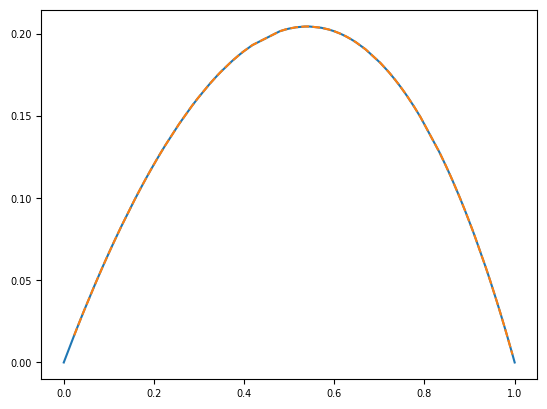

In [291]:
plt.plot(X, u(X))
plt.plot(X[1:-1], U, linestyle='dashed')

## 2b

We have two possible test solutions 
$$u_1(x) = x(1-x)$$
and
$$u_2(x) = sin(3 \pi x)$$
This gives the right hand sides 
$$f_1(x) = cx^2 + (c-2b)x + (b-2\alpha)$$
and 
$$f_2(x) = (9\pi^2\alpha+c)sin(3\pi x) + 3\pi b cos(3\pi x)$$
respectively. 

we implement the r.h.s:

In [292]:
def u2b_1(x):
    return x*(1-x)

def f2b_1(x, alpha=1, b=1, c=2):
    return -c*x**2 + (c-2*b)*x + (b+2*alpha)

def u2b_2(x):
    return np.sin(3*np.pi*x)

def f2b_2(x, alpha=1, b=1, c=2):
    return (9*np.pi**2 * alpha + c)*np.sin(3*np.pi*x) + 3*np.pi*b*np.cos(3*np.pi*x)

We then find the load vector and test the method:

[ 10  10  10  11  12  12  13  13  14  15  15  16  17  18  19  20  21  22
  23  24  25  26  28  29  30  32  33  35  37  39  40  42  44  47  49  51
  54  56  59  62  65  68  71  75  79  82  86  91  95 100]
[ 10  10  10  11  12  12  13  13  14  15  15  16  17  18  19  20  21  22
  23  24  25  26  28  29  30  32  33  35  37  39  40  42  44  47  49  51
  54  56  59  62  65  68  71  75  79  82  86  91  95 100]


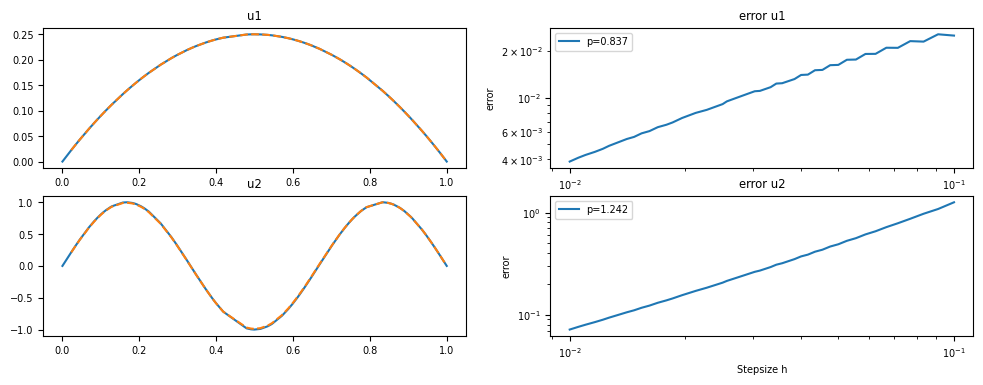

In [293]:
# here we construct the load-vector
F_2b1 = load_vector(f2b_1, X, M)
F_2b2 = load_vector(f2b_2, X, M)

# here we calculate the numerical solution
U_2b1 = np.linalg.solve(A, F_2b1)
U_2b2 = np.linalg.solve(A, F_2b2)

# now we also find the error
e1, H1 = loglog_error(f2b_1, u2b_1, norm="H1")
e2, H2 = loglog_error(f2b_2, u2b_2, norm="H1")

p1 = np.polyfit(np.log(H1), np.log(e1), 1)[0]
p2 = np.polyfit(np.log(H2), np.log(e2), 1)[0]

# Here we plit the figures
plt.figure(figsize=(12,4))

plt.subplot(2,2,1, title="u1")
plt.plot(X, u2b_1(X))
plt.plot(X[1:-1], U_2b1, linestyle='dashed')

plt.subplot(2,2,3,title="u2")
plt.plot(X, u2b_2(X))
plt.plot(X[1:-1], U_2b2, linestyle='dashed')

plt.subplot(2,2,2, title='error u1')
plt.loglog(H1, e1, label=f"p={p1:.3f}")
plt.xlabel('Stepsize h')
plt.ylabel('error')
plt.legend()

plt.subplot(2,2,4, title='error u2')
plt.loglog(H2, e2, label=f"p={p2:.3f}")
plt.xlabel('Stepsize h')
plt.ylabel('error')
plt.legend()

### 2d

$$
w_1(x) = \begin{cases}
2x &, \quad x \in \left(0, \frac{1}{2}\right) \\
2-2x &, \quad x \in \left(\frac{1}{2}, 1\right)
\end{cases}
$$

In [294]:
'''IMPLEMENTATION'''

def w1(x):
    return (x < 0.5) * 2*x + (x >= 0.5) * (2-2*x)
def f_w1(x, alpha=2, b=1, c=1):
    return (x < 0.5) * (c*2*x + 2*b) + (x >= 0.5) * (c*2*x - 2*b + 2*c)

def w2(x):
    return x - np.power(x, 2/3)
def f_w2(x, alpha=2, b=1, c=1):
    return -alpha*(2/9)*np.power(x, 4/3) + b - 2*b/(3*np.power(x,1/3)) + c*x - np.power(abs(x), 2/3)


In [295]:
'''INITIALIZATION'''

alpha = 2
b = 1
c = 1
M = 300
X = np.sort(np.random.random(M))
X[[0, -1]] = [0, 1]
H = np.diff(X)

# calculating numerical and analytical values of w1 and w2 based on X
A = stiffness_matrix(alpha, b, c, H, M)
F_w1 = load_vector(w1, X, M, elemental_load_vector_non_smooth_solution(alpha, b, c))
U_w1 = np.linalg.solve(A, F_w1)
F_w2 = load_vector(w2, X, M, elemental_load_vector_non_smooth_solution(alpha, b, c))
U_w2 = np.linalg.solve(A, F_w2)

# claculating error 
e_w1_L2, H_w1_L2 = loglog_error(w1, f_w1, norm='L2')
e_w1_H1, H_w1_H1 = loglog_error(w1, f_w1, norm='H1')

e_w2_L2, H_w2_L2 = loglog_error(w2, f_w2, norm='L2')
e_w2_H1, H_w2_H1 = loglog_error(w2, f_w2, norm='H1')



[ 10  10  10  11  12  12  13  13  14  15  15  16  17  18  19  20  21  22
  23  24  25  26  28  29  30  32  33  35  37  39  40  42  44  47  49  51
  54  56  59  62  65  68  71  75  79  82  86  91  95 100]
[ 10  10  10  11  12  12  13  13  14  15  15  16  17  18  19  20  21  22
  23  24  25  26  28  29  30  32  33  35  37  39  40  42  44  47  49  51
  54  56  59  62  65  68  71  75  79  82  86  91  95 100]
[ 10  10  10  11  12  12  13  13  14  15  15  16  17  18  19  20  21  22
  23  24  25  26  28  29  30  32  33  35  37  39  40  42  44  47  49  51
  54  56  59  62  65  68  71  75  79  82  86  91  95 100]
[ 10  10  10  11  12  12  13  13  14  15  15  16  17  18  19  20  21  22
  23  24  25  26  28  29  30  32  33  35  37  39  40  42  44  47  49  51
  54  56  59  62  65  68  71  75  79  82  86  91  95 100]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<module 'matplotlib.pyplot' from '/opt/homebrew/lib/python3.11/site-packages/matplotlib/pyplot.py'>

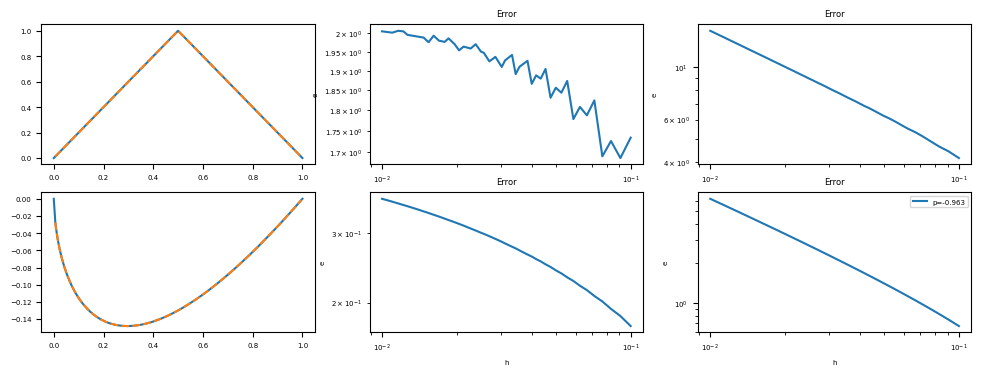

In [296]:

matplotlib.rcParams.update({'font.size': 5})
'''PLOTTING'''
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
fig.set_figwidth(12)
fig.set_figheight(4)
# plotting w1
ax1.plot(X, w1(X), label='analytical')
ax1.plot(X[1:-1], U_w1, label='numerical', linestyle='dashed')
# plotting error for w1 
loglogplot_error(H_w1_L2, e_w1_L2, ax2)
loglogplot_error(H_w1_H1, e_w1_H1, ax3)
# plottting w2
ax4.plot(X, w2(X), label='analytical')
ax4.plot(X[1:-1], U_w2, label='numerical', linestyle='dashed')
# plotting error for w1 
loglogplot_error(H_w2_L2, e_w2_L2, ax5)
loglogplot_error(H_w2_H1, e_w2_H1, ax6)

In [297]:
np.max(U)


0.20461735455271343

### Error in $L^2$ and $H^1$

In [298]:
simpsons_rule(*np.linspace(0, 1, 10, retstep=True))

0.46502057613168724

In [299]:
def simpsons_rule_2(f, dx):

    return (dx/3) * (f[0] + 2*np.sum(f[:-2:2]) + 4*np.sum(f[1:-1:2]) + f[-1])


for n in range(3, 20):
    print(f"n={n}: {simpsons_rule_2(*np.linspace(0, 1, n, retstep=True))}")
# print(simpsons_rule(x**2, dx))

n=3: 0.5
n=4: 0.2592592592592592
n=5: 0.5
n=6: 0.3333333333333333
n=7: 0.5
n=8: 0.37414965986394555
n=9: 0.5
n=10: 0.39917695473251025
n=11: 0.5
n=12: 0.4159779614325069
n=13: 0.5
n=14: 0.42800788954635116
n=15: 0.4999999999999999
n=16: 0.437037037037037
n=17: 0.5
n=18: 0.44405997693194926
n=19: 0.5
